# Analysis plan

In [ ]:
#
'''
# Yelp business model focal points (relevant to dataset): 
- two sides: personal users and businesses (primary source of revenue)
- revenue source: ads/traffic/Yelp reservation

# questions/objective:
- restaurants
    - what leads to more reviews and higher review stars?
    - target restaurants for sales 
- users
    - who are valuable users (giving more reviews with good quality)?
    - how to improve engagement?
    - target audience market for user acquisition (need more info)
- reviews
    - what kind of reviews are found more useful?
    - lenth vs stars
    
--- parking lot ---
- geo vs review/activity density
- geo vs restaurant type preferrence

# assumptions (or will need to check)
- the dataset of reviews is a random sample and is good representation of all the reviews 
- 

# insights
- 

# next steps (further data collection, model, test, etc) 
- NLP, classify reviews
- time analysis

# recommendation for change of design of search page
'''

# Loading

In [2]:
# -load
p1 = '/Users/sz/sz_projects/Yelp_dataset/Yelp Takehome Dataset/charlotte_review.csv'
p2 = '/Users/sz/sz_projects/Yelp_dataset/Yelp Takehome Dataset/charlotte_reviewer.csv'
p3 = '/Users/sz/sz_projects/Yelp_dataset/Yelp Takehome Dataset/charlotte_business.csv'
p4 = '/Users/sz/sz_projects/Yelp_dataset/Yelp Takehome Dataset/charlotte_data_joined.csv'
review = pd.read_csv(p1)
reviewer = pd.read_csv(p2)
business = pd.read_csv(p3)
joined = pd.read_csv(p4)
# data shape
dfs = zip(['review','reviwer','business','joined'],[review,reviewer,business,joined])
print [(i[0],i[1].shape) for i in dfs]

[('review', (54222, 10)), ('reviwer', (16518, 14)), ('business', (1381, 23)), ('joined', (54222, 45))]


# Data QA and prep

In [42]:
# -sample
#review.sample(100)
# -any missing data? business table has some null in these columns
for df in [review, reviewer, business]:
    c = df.count()
    print c[c<>len(df)]
# -do foreign keys match perfectly? Yes.
#len(review[~review.reviewer_id.isin(reviewer.reviewer_id)])
#len(reviewer[~reviewer.reviewer_id.isin(review.reviewer_id)])
#len(review[~review.business_id.isin(business.business_id)])
#len(business[~business.business_id.isin(review.business_id)])
# -any duplicates? No.
#review.duplicated().sum()
#reviewer.duplicated().sum()
#business.duplicated().sum()

Series([], dtype: int64)
Series([], dtype: int64)
business_Take-out                1326
business_Alcohol                 1194
business_NoiseLevel              1172
business_Attire                  1303
business_Delivery                1292
business_HasTV                   1239
business_TakesReservations       1310
business_WheelchairAccessible     704
business_WaiterService           1221
business_AcceptsCreditCards      1322
business_GoodforKids             1309
business_GoodForGroups           1316
business_PriceRange              1318
dtype: int64


In [6]:
# -Tableau data source
business['zip'] = business.business_full_address.str[-5:]
business.drop('business_full_address', axis=1).to_csv('business_tableau.txt', index=False)

# Data Exploration

In [92]:
#review.head()
review.dtypes

review_date             object
review_id               object
review_stars           float64
review_text             object
review_funny_votes       int64
review_useful_votes      int64
review_cool_votes        int64
review_total_votes       int64
reviewer_id             object
business_id             object
month                   object
year                    object
dtype: object

## - Engagement over time
- time range: 2005 ~ 2014 (data not available for whole month/year in 2004 and 2015)
- overall: reviews, reviewers, restaurants are increasing every year (table below)
- per reviewer/restaurant: count of reviews are increasing (chart below)

Overall:


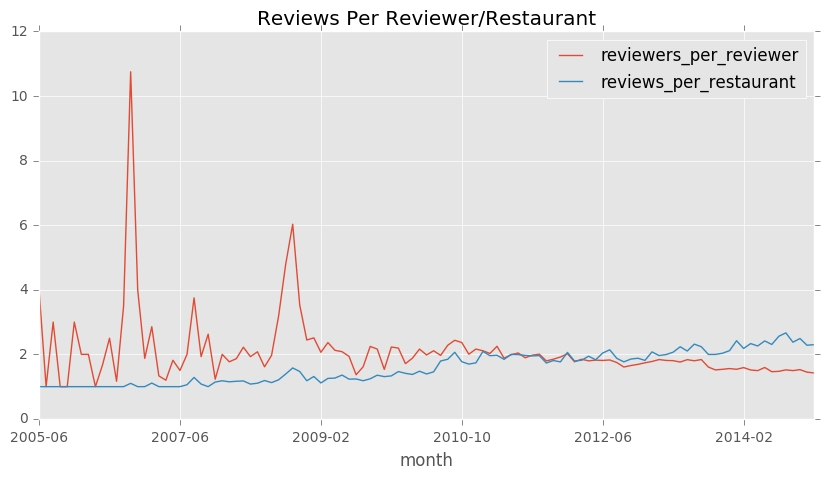

In [80]:
# -Engagement over time
#print review.review_date.min(), review.review_date.max() # 2004 and 2015 didn't have complete month/year
#review['month'] = review.review_date.str[:7]
#review['year'] = review.review_date.str[:4]
con_ex = (review.year<'2015') & (review.year>'2004')
gp_mh = review[con_ex].groupby('month') 
gp_yr = review[con_ex].groupby('year')

# -overall:
print 'Overall:'
from prettypandas import PrettyPandas as pp
ct_overall = gp_yr['review_id','reviewer_id','business_id'].agg(lambda x: x.nunique())
ct_overall.columns = ['reviews','reviewers','restaurants']
ct_overall['delta_reviews'] = ct_overall.reviews.pct_change()
ct_overall['delta_reviewers'] = ct_overall.reviewers.pct_change()
ct_overall['delta_restaurants'] = ct_overall.restaurants.pct_change()
pp(ct_overall[ct_overall.index>'2005']).as_percent([i for i in ct_overall.columns if 'delta' in i])

# -per reviewer/restaurant
rpb = review[con_ex].groupby(['month','business_id'], as_index=False).size().reset_index().groupby(['month'])[0].mean()
rpr = review[con_ex].groupby(['month','reviewer_id'], as_index=False).size().reset_index().groupby(['month'])[0].mean()
df_per = pd.DataFrame({'reviewers_per_reviewer': rpr, 'reviews_per_restaurant':rpb})
df_per.plot(title='Reviews Per Reviewer/Restaurant', figsize=(10,5))

In [122]:
# -spike in Nov 2006 (outliers to be exluded for analysis later)
#rpr.sort_values(ascending=False)
#rpr.plot(kind='box');
review[review.month=='2006-11'].groupby('reviewer_id').size().sort_values(ascending=False)
# -one reviewer gave 37 reviews that month
#reviewer[reviewer.reviewer_id =='K5dxGhJ99TmS6La6krwkcg']
review[['review_stars','review_text']][review.reviewer_id =='K5dxGhJ99TmS6La6krwkcg'].sample(10) # reviews all seem legit
# -but he doesn't usually write as many review in a month...
review[review.reviewer_id =='K5dxGhJ99TmS6La6krwkcg'].groupby('month').size().mean()

reviewer_id
K5dxGhJ99TmS6La6krwkcg    37
llkm_iXQszkN5DZvmqjNqA     4
mGSyq3buf9AggxuXuZRkyQ     1
K7KeCgY2G2OUKCrhgWsd8A     1
dtype: int64

,review_stars,review_text
15834,3.0,This is a great place to get all kinds of bar ...
6636,3.0,"The pizza here is good, but not great. There ..."
7110,2.0,Pike's was always the place we went to grab on...
7397,4.0,"Showmar's, like many of the restaurants in Cha..."
16390,4.0,This is a nice little Mexican place- the food...
11489,2.0,"If I could I would give this place a 2.5, but ..."
5922,4.0,Yummmmmm! This place has great sandwiches and...
13980,2.0,I went to the Fig Tree thinking it was going t...
6792,3.0,"Ok, this place can be a great little neighborh..."
3034,4.0,The Chicken Box is awesome! This place totall...


4.133333333333334

## - Reviewers and restaurants

# Modeling and testing

## - What leads to more reviews?

## - What leads to higher review stars?

## - Target restaurants for sales

## - User analysis
- who are valuable users?
- how to increase engagement